In [39]:
import donkeycar as dk
import keras
import os
import numpy as np
import pandas as pd
from donkeycar import utils
from PIL import Image
from donkeycar.tools.fisheye_undistort import undistort
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [16, 8]

In [42]:
def dataset_from_tub(tub_path, limit=500):
    tub = dk.parts.Tub(tub_path)
    idx = tub.get_index(shuffled=False)
    img_in = []
    angle_out = []
    throttle_out = []
    if limit==-1:
        limit = len(idx)

    for i in range(limit):
        rec = tub.get_record(idx[i])
        img_in.append(rec['cam/image_array'])
        angle_out.append(rec['user/angle'])
        throttle_out.append(rec['user/throttle'])
    return (np.array(img_in), np.array(angle_out), np.array(throttle_out))

def dataset_from_all_tubs(data_path):
    tub_paths = [os.path.join(data_path, n) for n in os.listdir(data_path)]
    datasets = [dataset_from_tub(p, limit=-1) for p in tub_paths]
    img_in = [ds[0] for ds in datasets]
    angle_out = [ds[1] for ds in datasets]
    throttle_out = [ds[2] for ds in datasets]
    return (np.concatenate(img_in), np.concatenate(angle_out), np.concatenate(throttle_out))

def bin_angle_out(angle_out):
    return np.array([dk.utils.linear_bin(o) for o in angle_out])

def output_pair_cat(model, dataset):
    img_in, angle_out, throttle_out = dataset
    angle_binned, throttle = model.predict(img_in)
    predicted = dk.utils.unbin_Y(angle_binned)
    return (predicted, angle_out)

def output_pair_lin(model, dataset):
    img_in, angle_out, throttle_out = dataset
    predicted, throttle = model.predict(img_in)
    return (predicted, angle_out)

# Img_in

Tub does exist
Predicted steering angle: -0.2857142857142858 - Actual: -0.265073


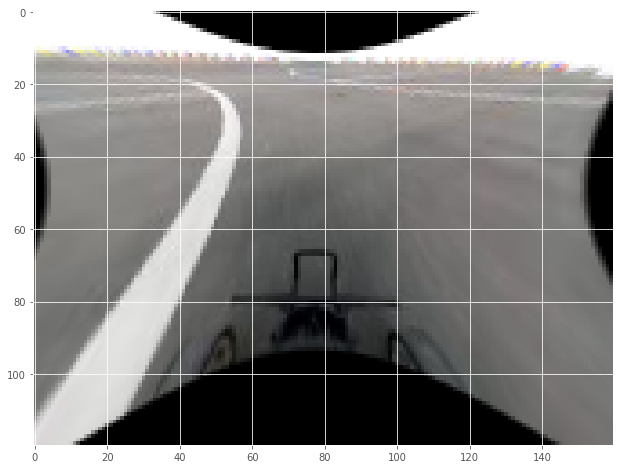

In [25]:
model = keras.models.load_model('../../donkeycar/d2/models/ws.cls.nb.undistort.0.79')
dataset = dataset_from_tub('../../donkeycar/d2/data.ws.test/tub_golden1')
predicted, actual = output_pair_cat(model, dataset)
i = 100
print("Predicted steering angle: {} - Actual: {}".format(predicted[i], actual[i]))
img_in = dataset[0][[i]]
plt.imshow(img_in[0])

In [44]:
from keras.models import *
from keras.callbacks import *
from keras.layers import Lambda, Convolution2D, Activation, Dropout, Flatten, Dense
from keras.layers import Dense, Lambda, ELU
from keras.layers import Dense, Activation, Reshape, Merge
from keras.layers.pooling import MaxPooling2D, AveragePooling1D
from keras.layers import Merge
import keras.backend as K
import cv2
import argparse
import pickle
from keras.models import load_model
from keras.layers import Convolution2D, MaxPooling2D, Activation, Lambda, Input, Deconvolution2D, Flatten, Dense, Reshape, ZeroPadding2D, Cropping2D
from keras.layers import Merge
from keras.models import Sequential
from keras import backend as K
from keras.layers import merge
import keras

from distutils.version import LooseVersion

import numpy as np
import matplotlib.pyplot as plt
import cv2  # only used for loading the image, you can use anything that returns the image as a np.ndarray
from PIL import Image, ImageEnhance, ImageOps

import matplotlib.cm as cm
from keras.models import Model


def almostEquals(a,b,thres=50):
    return all(abs(a[i]-b[i])<thres for i in range(len(a)))


#
#  Create the models
#

def activationModel(model):
  # grab the conv layers
  current_stack=[]
  act_stack=[]
  for layer in model.layers:
    if layer.name.startswith("conv"):
        current_stack.insert(0, layer)
        print('*********8')
        print(layer.outbound_nodes[0].outbound_layer.name)
        nextlayer=layer.outbound_nodes[0].outbound_layer;
        print(nextlayer.name)
        if (nextlayer.name.startswith("elu")):
           act_stack.insert(0, nextlayer)
        elif (nextlayer.name.startswith("activ")):
           act_stack.insert(0, nextlayer)
        else:
           act_stack.insert(0, layer)

  # grab the activation layers connected to the conv layers
  # TODO - this is a bad way to do it!!
  #for layer in model.layers:
  #  if layer.name.startswith("activ"):
  #      act_stack.insert(0, layer)

  #if (len(act_stack)==0):
  #  for layer in model.layers:
  #    if layer.name.startswith("elu"):
  #      act_stack.insert(0, layer)


  #if (len(act_stack)<len(current_stack)):
  #  act_stack.insert(0,current_stack[0])
  #start=len(act_stack)-len(current_stack)
  #act_stack=act_stack[start:]

  #current_stack.pop(0)
  #act_stack.pop(0)

  print("current stack:")
  for layer in current_stack:
    print(layer.name)
    #print(layer.outbound_nodes[0].outbound_layer.name)
  print("act stack:")
  for layer in act_stack:
    print(layer.name)
  print("---------")



  lastone=None
  #  hold onto last one..
  for i, layer in enumerate(current_stack):
    print(layer.name,i)
    our_shape=(layer.output_shape[1],layer.output_shape[2],1)
    hidden_layer = act_stack[i]
    print(hidden_layer.name)
    print(layer.name)
    print(our_shape)
    # average this layer
    name='lambda_new_'+str(i)
    c1=Lambda(lambda xin: K.mean(xin,axis=3),name=name)(hidden_layer.output)
    name='reshape_new_'+str(i)
    r1=Reshape(our_shape,name=name)(c1)
    #lastone=r1
    if (i!=0):
       # if we aren't the bottom, multiply by output of layer below
       print("multiply")
       name='multiply_'+str(i)
       r1 = merge([r1,lastone], mode='mul', name = name)
       lastone=r1


    if (i<len(current_stack)-1):
        print('do deconv')
        # deconv to the next bigger size
        bigger_shape=current_stack[i+1].output_shape
    else:
        bigger_shape=model.input_shape


    bigger_shape=(bigger_shape[0],bigger_shape[1],bigger_shape[2],1)

    if (LooseVersion(keras.__version__) > LooseVersion("2.0.0")):
      print ("Keras 2")
      subsample=current_stack[i].strides
      nb_row,nb_col=current_stack[i].kernel_size
    else:
      subsample=current_stack[i].subsample
      nb_row=current_stack[i].nb_row
      nb_col=current_stack[i].nb_col
    print("deconv params:")
    print("subsample:",subsample)
    #nb_row,nb_col=current_stack[i].kernel_size
    print("nb_col,nb_row:",nb_col,nb_row)
    print("bigger_shape:",bigger_shape)
    name='deconv_new_'+str(i)
    print(name)
    print('Deconvolution2D(1,',nb_row, nb_col,'output_shape=',bigger_shape,'subsample= ',subsample,'border_mode=valid','activation=relu','init=one','name=',name)
    d1 = Deconvolution2D(1, nb_row, nb_col,output_shape=bigger_shape,subsample= subsample,border_mode='valid',activation='relu',init='one',name=name)(r1)

    #attrs = vars(d1)
    #print (', '.join("%s: %s" % item for item in attrs.items()))

    if (d1._keras_shape[1]!=bigger_shape[1]):
       print("d1:",d1._keras_shape)
       pad=0
       if (d1._keras_shape[1]<bigger_shape[1]):
         if (d1._keras_shape[2]!=bigger_shape[2]):
            pad=1
         else:
            pad=0
         z1 = ZeroPadding2D(padding=(1, pad), data_format=None)(d1)
         c1 = Cropping2D(cropping=((1, 0), (pad, 0)) , data_format=None)(z1)
         print("z1:",z1._keras_shape)
       else:
         print("making smaller")
         padx=d1._keras_shape[1] - bigger_shape[1]
         pady=d1._keras_shape[2] - bigger_shape[2]
         print("padx,pady",padx,pady)
         c1 = Cropping2D(cropping=((padx, 0), (pady, 0)) , data_format=None)(d1)
       print("c1:",c1._keras_shape)
       lastone=c1
    else:
       lastone=d1

    #d4 = Deconvolution2D(1, 3, 3,output_shape=(None,4,17,1),subsample= (2, 2),border_mode='valid',activation='relu',init='one')(r4)



  model2 = Model(input=model.input,output=[lastone])
  model2.summary()

  return model2


def highlightBackProp(image,model2):

    #steering_angle = float(model.predict(image[None, :, :, :], batch_size=1))
    #   print(image.shape)
    #image = cv2.resize(image, (256, 256) )
    oldimage = image
    #image = cv2.resize(image, (200, 66) )

    # transpose if model is other way
    count, h, w, ch = model2.inputs[0].get_shape()
    ih, iw, ich = image.shape
    if h == ich and ch == ih:
       image= image.transpose()

    print(image.shape)
    m1d = model2.predict(image[None, :, :, :], batch_size=1)
    print(m1d.shape)
    m1d = np.squeeze(m1d, axis=0)
    m1d = np.squeeze(m1d, axis=2)
    #m1d = cv2.resize(image, (120, 160) )

    #m1d=np.resize(m1d,(120,160))
    #print(m1d.shape)

    #print(m1d)
    #plt.hist(m1d[::-1])
    #plt.show()
    #print(m1d.max())
    #print(m1d.min())
    o2=overlay = Image.fromarray(cm.Reds(m1d/m1d.max(), bytes=True))
    #o2= o2.convert("RGB")
    #return o2
    #plt.imshow(o2);
    #plt.show();

    pixeldata = list(overlay.getdata())

    for i,pixel in enumerate(pixeldata):
        if almostEquals(pixel[:3], (255,255,255)):
            pixeldata[i] = (255,255,255,0)
        else:
            pixeldata[i]= (pixel[0],pixel[1],pixel[2],128)

    overlay.putdata(pixeldata)
    #obig= cv2.resize(overlay, (320, 160) )

    carimg = Image.fromarray(np.uint8(image))
    #carimg = Image.fromarray(np.uint8(oldimage))
    carimg = carimg.convert("RGBA")
    new_img2=Image.alpha_composite(carimg, overlay)
    new_img2= new_img2.convert("RGB")
    o2= o2.convert("RGB")
    #plt.imshow(o2);
    #plt.show();
    return np.array(new_img2)

*********8
conv2d_2
conv2d_2
*********8
conv2d_3
conv2d_3
*********8
conv2d_4
conv2d_4
*********8
conv2d_5
conv2d_5
*********8
flattened
flattened
current stack:
conv2d_5
conv2d_4
conv2d_3
conv2d_2
conv2d_1
act stack:
conv2d_5
conv2d_4
conv2d_3
conv2d_2
conv2d_1
---------
conv2d_5 0
conv2d_5
conv2d_5
(3, 6, 1)
do deconv
Keras 2
deconv params:
subsample: (1, 1)
nb_col,nb_row: 3 3
bigger_shape: (None, 5, 8, 1)
deconv_new_0
Deconvolution2D(1, 3 3 output_shape= (None, 5, 8, 1) subsample=  (1, 1) border_mode=valid activation=relu init=one name= deconv_new_0
conv2d_4 1
conv2d_4
conv2d_4
(5, 8, 1)
multiply
do deconv
Keras 2
deconv params:
subsample: (2, 2)
nb_col,nb_row: 3 3
bigger_shape: (None, 12, 17, 1)
deconv_new_1
Deconvolution2D(1, 3 3 output_shape= (None, 12, 17, 1) subsample=  (2, 2) border_mode=valid activation=relu init=one name= deconv_new_1
d1: (None, 11, 17, 1)
z1: (None, 13, 17, 1)
c1: (None, 12, 17, 1)
conv2d_3 2
conv2d_3
conv2d_3
(12, 17, 1)
multiply
do deconv
Keras 2
deconv p

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:137: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(1, (3, 3), strides=(1, 1), name="deconv_new_0", activation="relu", padding="valid", kernel_initializer="one")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:107: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/ubuntu/.local/lib/python3.5/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:137: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(1, (3, 3), strides=(2, 2), name="deconv_new_1", activation="relu", padding="valid", kernel_initializer="one")`
/u

(1, 120, 160, 1)


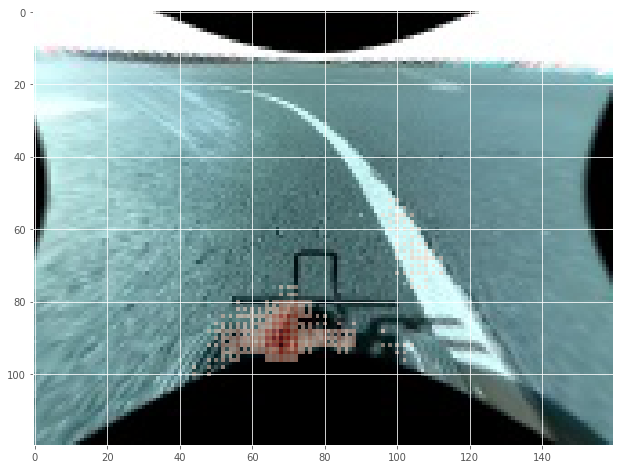

In [37]:
actModel = activationModel(model)
from keras.preprocessing import image
img_in = image.load_img("../../donkeycar/d2/jpgs1/23:40:06.320933_[[ 0.16830643]].jpg")
img_in = np.array(img_in)
img = highlightBackProp(img_in, actModel)
plt.imshow(img)
angle, _ = model.predict(np.expand_dims(img_in, axis=0))

In [38]:
dk.utils.unbin_Y(angle)

array([ 0.14285714])

# Grad-CAM heatmap

In [13]:
from keras.preprocessing import image
from keras.models import load_model
from tensorflow.python.framework import ops
import keras.backend as K
import datetime
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2
import os
import tempfile
import shutil
from subprocess import call

import donkeycar as dk

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(img_path):
    img = image.load_img(img_path, target_size=(120, 160))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='conv2d_5'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = load_model(modelpath)
    return new_model

functions = {}

def grad_cam(input_model, image, category_index, layer_name):
    model = input_model
    nb_classes = 15
    f = None

    if category_index in functions:
        f = functions[category_index]
    else:
        loss = model.output[0][:, category_index]
        conv_output = model.get_layer(layer_name).output
        grads = normalize(K.gradients(loss, conv_output)[0])
        f = K.function([model.input, K.learning_phase()], [conv_output, grads])
        functions[category_index] = f

    output, grads_val = f([image, 1])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (160, 120))
    cam = np.maximum(cam, 1)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    #image += 0.5
    #image *= 255
    #image -= np.min(image)
    #image = np.minimum(image, 255)

    cam = mix_heatmap(image, heatmap)
    return cam, heatmap


def mix_heatmap(img, heatmap):
    if len(img.shape) > 3:
        img = img[0]
    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_HOT)
    cam = np.float32(cam) + np.float32(img)
    cam = 255 * cam / np.max(cam)
    cam = np.uint8(cam)
    return cam

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def overlay_gradcam(img_in, model):
    img_in = img_in.reshape((1,) + img_in.shape)
    predicted_angle, _ = model.predict(img_in)
    predicted_class = np.argmax(predicted_angle[0])
    cam, heatmap = grad_cam(model, img_in, predicted_class, 'conv2d_5')
    from IPython.core.debugger import set_trace
    set_trace()
    img =  mix_heatmap(img_in, heatmap)
    return img

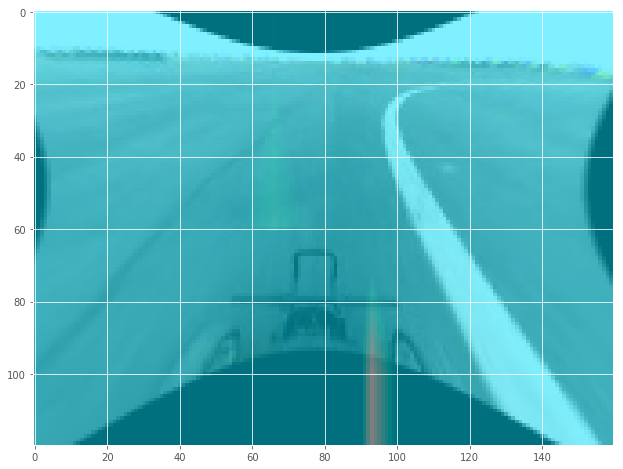

In [14]:
predicted_angle, _ = model.predict(img_in)
predicted_class = np.argmax(predicted_angle[0])
cam, heatmap = grad_cam(model, img_in, predicted_class, 'conv2d_5')
plt.imshow(cam)

# Guided Saliency Objects

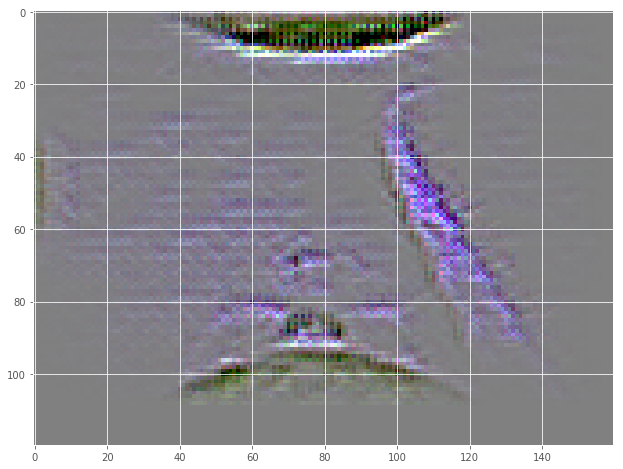

In [15]:
modelpath = '../../donkeycar/d2/models/oak'

register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([img_in, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]
plt.imshow(deprocess_image(gradcam))

# 1st Conv layer activation tiles

In [70]:
import keras.backend as K
import math


def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

def activation_tiles(model, img_in, layer_index):
    activation = get_activations(model, img_in, print_shape_only=True)[layer_index][0]
    activation = np.transpose(activation, (2, 0, 1))

    rows = math.ceil(len(activation)/8)
    fig, subplts = plt.subplots(rows,8)

    for i in range(rows):
        for j in range(8):
            subplt = subplts[i][j]
            subplt.axis('off')
            subplt.imshow(activation[i*6+j], interpolation='None', cmap='hot')

----- activations -----
(1, 120, 160, 3)
(1, 58, 78, 24)
(1, 27, 37, 32)
(1, 12, 17, 64)
(1, 5, 8, 64)
(1, 3, 6, 64)
(1, 1152)
(1, 100)
(1, 100)
(1, 50)
(1, 50)
(1, 15)
(1, 1)


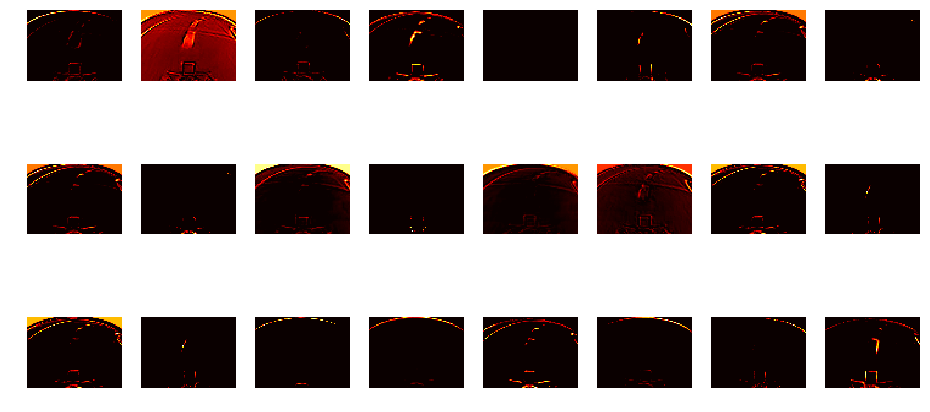

In [71]:
activation_tiles(model, img_in, 1)

# 1st Conv layer filter weights

*Question: these filters don't seem to be visually identifiable. Does it mean we need a bigger kernel (7x7, 11x11)?

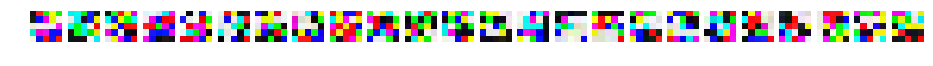

In [64]:
fl1 = model.layers[1].get_weights()[0]
fl1 = np.transpose(fl1, (3, 0, 1, 2))
fl1.shape
fig, subplts = plt.subplots(1,24)
for i, subplt in enumerate(subplts):
    subplt.axis('off')
    subplt.imshow(fl1[i])
# plt.imshow(fl1[0])